In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pymorphy2
import urllib.request
import json   
import requests

from pymorphy2.tokenizers import simple_word_tokenize
from pymorphy2.shapes import is_punctuation
from collections import Counter
from stop_words import get_stop_words
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.externals import joblib

In [18]:
df = pd.read_csv("../data/itil-tickets-6.csv", sep=',')
# df = pd.read_clipboard()
# df.to_csv('../data/itil-tickets-6.csv', index=False)
# df = df.dropna()
df.sample(n=5).head()

,route,specialist,title,category,analytics1,analytics2,analytics3,user
5984,зо,Талаева Вера,срочно,Консультация,Розничный отдел,1С УТ 11,Поддержка УТ11,Севернева Вероника
1709,зо,Быков Вадим,FW: ключ для нового сотрудника,Hardware::Smartcards,Складская служба,Ключ доступа,Поддержка инфраструктуры,Шевченко Александр
2562,зо,Талаева Вера,ITIL. Проверка работы с вложениями.,Администрирование 1С,Отдел разработки 1С,1С ITIL,Поддержка 1C ITIL,Зезюлькин Сергей
11836,зо,Талаева Вера,удалить контрагента,Изменение данных,Отдел ВЭД,1С УТ 11,Поддержка УТ11,Кучинская Анастасия
5437,зо,Талаева Вера,ВАЖНО СРОЧНО,Консультация,Транспортная логистика,1С УТ 11,Поддержка УТ11,Пролыгина Инесса


In [19]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data.head()

,route,specialist,title,category,analytics1,analytics2,analytics3,user
13936,зи,Талаева Вера,Возможность сделать 2 поступления на основании...,Незначительная доработка,Маркетинг,1С УТ 11,Поддержка УТ11,Талаева Вера
13845,зи,Манюхин Андрей,УТ - склад - заказ на перемещение товаров - ро...,Незначительная доработка,Розничный магазин,1С Розница для Беларуси,Поддержка Розница,Талаева Вера
2457,зо,Малеев Егор,"1С УТ - кредитный контроль, распределение плат...",Изменение данных,Финансовый отдел,1С УТ 11,Кредитный контроль / Планирование денежных сре...,Пискуровская Елена
8779,зо,Талаева Вера,Заменены в реализациях договора.,Изменение данных,Офистон,1С УТ 11,Поддержка УТ11,Подберезская Татьяна (Могилев)
9559,зо,Талаева Вера,подхватывается не та позиция с нанесением лого...,Консультация,Логотон,1С УТ 11,Поддержка УТ11,Кропис Юлия


### Elastic Search Baseline

### Preprocessing

In [23]:
df['specialist'].replace(['Руководители службы Service Desk', 'Шкурупий Денис'], 'Манюхин Андрей', inplace=True)
df['specialist'].replace('Кухарчук Дмитрий', 'Сергиевич Юрий', inplace=True)
df['specialist'].replace('Талаева Вера', 'Кропис Юлия', inplace=True)
df['specialist'].replace('Быков Вадим', 'Полегошко Андрей', inplace=True)

grouped = df['specialist'].value_counts()
print(grouped.index[0], grouped.iloc[0]/grouped.sum())

users_minor = grouped[grouped<=10]
print(users_minor)

Кропис Юлия 0.31438858171531436
Series([], Name: specialist, dtype: int64)


In [22]:
for um in users_minor.index:
    df = df.loc[df['specialist']!=um]

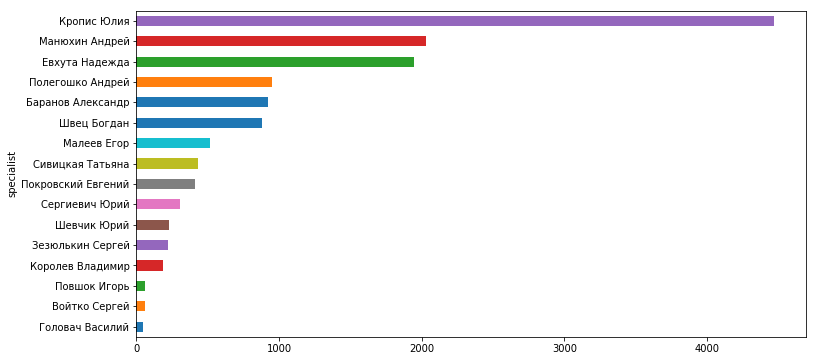

In [10]:
fig = plt.figure(figsize=(12,6))
df.groupby('specialist').title.count().sort_values(ascending=True).plot.barh(ylim=0)
plt.savefig('specialists.png')
plt.show()

In [11]:
def replace_by_re(s, pattern, repl):
    return re.sub(pattern, repl, s)

df['title'] = df['title'].apply(replace_by_re, args=('1[CСcс]', "1С"))
df['title'] = df['title'].apply(replace_by_re, args=('FW:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('RE:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('(\d{2}[\.\\\/]){2}(\d{2})+', "дата"))
# df['title'] = df['title'].apply(replace_by_re, args=("[\:\#\№%\!\d\-\'\.]", ""))
# df['title'] = df['title'].apply(replace_by_re, args=('\"', ""))

df = df[df['title']!='']

df['title'].loc[:10]

0         проверка работы
2                   Test!
3    Проверка работы itil
4                 Test md
6    Проверка работы ITIL
8                проверка
9                    Test
Name: title, dtype: object

In [12]:
df.shape

(13662, 3)

In [13]:
morph = pymorphy2.MorphAnalyzer()
cnt = Counter()
stop_words = get_stop_words('russian')

def lemmatize(s):
    l = [morph.parse(w)[0].normal_form for w in simple_word_tokenize(s) if not is_punctuation(w)]
    l = [w for w in l if w not in stop_words]
    
    cnt.update(l)
    
    return " ".join(l)

df['title'] = df['title'].apply(lemmatize)

df['title'].loc[:10]

0         проверка работа
2                    test
3    проверка работа itil
4                 test md
6    проверка работа itil
8                проверка
9                    test
Name: title, dtype: object

In [14]:
df.shape

(13662, 3)

### Transform

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(df.title).toarray()
labels = df.category_id
features.shape

(13662, 2411)

In [16]:
fnames = tfidf.get_feature_names()
print(fnames[-10:])

['этап', 'этикетка', 'юр', 'юр адрес', 'юрист', 'язык', 'январь', 'ярлык', 'ячейка', 'ящик']


### Model Search

In [17]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=42)

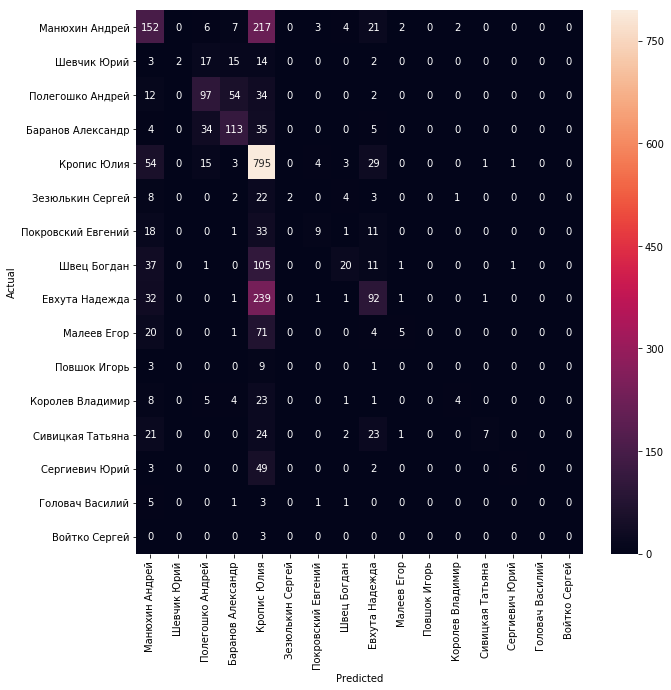

In [18]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.specialist.values, yticklabels=category_id_df.specialist.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('heatmap.png')

In [19]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))

                    precision    recall  f1-score   support

    Манюхин Андрей       0.40      0.37      0.38       414
       Шевчик Юрий       1.00      0.04      0.07        53
  Полегошко Андрей       0.55      0.49      0.52       199
 Баранов Александр       0.56      0.59      0.58       191
       Кропис Юлия       0.47      0.88      0.62       905
  Зезюлькин Сергей       1.00      0.05      0.09        42
Покровский Евгений       0.50      0.12      0.20        73
       Швец Богдан       0.54      0.11      0.19       176
    Евхута Надежда       0.44      0.25      0.32       368
       Малеев Егор       0.50      0.05      0.09       101
      Повшок Игорь       0.00      0.00      0.00        13
  Королев Владимир       0.57      0.09      0.15        46
  Сивицкая Татьяна       0.78      0.09      0.16        78
    Сергиевич Юрий       0.75      0.10      0.18        60
   Головач Василий       0.00      0.00      0.00        11
     Войтко Сергей       0.00      0.00

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
model.fit(features, labels)
N = 2
for specialist, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(specialist))
  print("  . Top unigrams: {}".format(', '.join(unigrams)))
  print("  . Top bigrams: {}".format(', '.join(bigrams)))

# 'Баранов Александр':
  . Top unigrams: переадресация, доступ
  . Top bigrams: работать телефон, переадресация почта
# 'Войтко Сергей':
  . Top unigrams: сотрудник, новый
  . Top bigrams: новый сотрудник, доступ 1с
# 'Головач Василий':
  . Top unigrams: сайт, белкантон
  . Top bigrams: сайт белкантон, сайт бкг
# 'Евхута Надежда':
  . Top unigrams: подарок, база
  . Top bigrams: орг вопрос, розница орг
# 'Зезюлькин Сергей':
  . Top unigrams: 1с, база
  . Top bigrams: копия база, база 1с
# 'Королев Владимир':
  . Top unigrams: доступ, новый
  . Top bigrams: учётный запись, новый сотрудник
# 'Кропис Юлия':
  . Top unigrams: реализация, база
  . Top bigrams: висеть база, зона доставка
# 'Малеев Егор':
  . Top unigrams: себестоимость, срочно
  . Top bigrams: 1с ут, гтд москва
# 'Манюхин Андрей':
  . Top unigrams: заказ, отчёт
  . Top bigrams: печатный форма, заказ клиент
# 'Повшок Игорь':
  . Top unigrams: сайт, офисмама
  . Top bigrams: сайт офистон, личный кабинет
# 'Покровский Евгений':

In [21]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))

                    precision    recall  f1-score   support

    Манюхин Андрей       0.40      0.37      0.38       414
       Шевчик Юрий       1.00      0.04      0.07        53
  Полегошко Андрей       0.55      0.49      0.52       199
 Баранов Александр       0.56      0.59      0.58       191
       Кропис Юлия       0.47      0.88      0.62       905
  Зезюлькин Сергей       1.00      0.05      0.09        42
Покровский Евгений       0.50      0.12      0.20        73
       Швец Богдан       0.54      0.11      0.19       176
    Евхута Надежда       0.44      0.25      0.32       368
       Малеев Егор       0.50      0.05      0.09       101
      Повшок Игорь       0.00      0.00      0.00        13
  Королев Владимир       0.57      0.09      0.15        46
  Сивицкая Татьяна       0.78      0.09      0.16        78
    Сергиевич Юрий       0.75      0.10      0.18        60
   Головач Василий       0.00      0.00      0.00        11
     Войтко Сергей       0.00      0.00

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
joblib.dump(model, 'itil-multinb.pkl')
joblib.dump(tfidf, 'itil-tfidf.pkl')

['itil-tfidf.pkl']

# doc2vec

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess

In [ ]:
def tag_docs(docs, col, label): 
    tagged = docs.apply(lambda r: TaggedDocument(words=simple_preprocess(r[col]), tags=[r[label]]),  axis=1) 
    return tagged

def train_doc2vec_model(tagged_docs): 
    sents = tagged_docs.values
    doc2vec_model = Doc2Vec(sents, epochs=20, dm=1) #size=size, window=window, 
    return doc2vec_model

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values 
    targets, regressors =  zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
train_tagged = tag_docs(train_data, 'title', 'specialist')
test_tagged = tag_docs(test_data, 'title', 'specialist')
model = train_doc2vec_model(train_tagged)

In [ ]:
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))